## Handwritten Digits Generator With a GAN

* Generative adversarial networks can also generate high-dimensional samples such as images.
* we going to use a GAN to generate images of handwritten digits
* train the models using the MNIST dataset of handwritten digits

### import libraries

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms


In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Preparing the Training Data

* The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9
* To use them with PyTorch, we need to perform some conversions. For that, we define transform, a function to be used when loading the data:

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

The function has two parts:
* transforms.ToTensor() converts the data to a PyTorch tensor.
* transforms.Normalize() converts the range of the tensor coefficients.

* The original coefficients given by transforms.ToTensor() range from 0 to 1, and since the image backgrounds are black, most of the coefficients are equal to 0 when they’re represented using this range.
* transforms.Normalize() changes the range of the coefficients to -1 to 1 by subtracting 0.5 from the original coefficients and dividing the result by 0.5.
*  transforms.Normalize() are two tuples, (M₁, ..., Mₙ) and (S₁, ..., Sₙ), with n representing the number of channels of the images. 
* Grayscale images such as those in MNIST dataset have only one channel, so the tuples have only one value. 
* for each channel i of the image, transforms.Normalize() subtracts Mᵢ from the coefficients and divides the result by Sᵢ

load the training data using torchvision.datasets.MNIST and perform the conversions using transform:

In [5]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

* The argument download=True ensures that the first time you run the above code, the MNIST dataset will be downloaded and stored in the current directory, as indicated by the argument root.

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

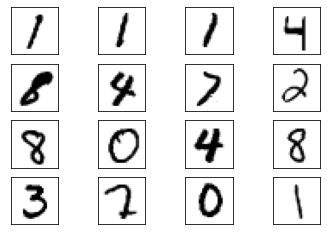

In [8]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

### Implementing the Discriminator

* In this case, the discriminator is an MLP neural network that receives a 28 × 28 pixel image and 
* provides the probability of the image belonging to the real training data.

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

* To input the image coefficients into the MLP neural network, 
* vectorize them so that the neural network receives vectors with 784 coefficients.
* The vectorization occurs in the first line of .forward(), as the call to x.view() converts the shape of the input tensor. 
* In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up.
* After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.
* To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to()

In [10]:
discriminator = Discriminator().to(device=device)

### Implementing the generator

* Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space.
* In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image.

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

* hyperbolic tangent function Tanh() as the activation of the output layer since the output coefficients should be in the interval from -1 to 1. 


### Training the Models

In [12]:
lr = 0.0001
# num_epochs = 50
num_epochs = 5
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5692477226257324
Epoch: 0 Loss G.: 0.47790801525115967
Epoch: 1 Loss D.: 0.009643511846661568
Epoch: 1 Loss G.: 5.8984527587890625
Epoch: 2 Loss D.: 0.011027583852410316
Epoch: 2 Loss G.: 5.060005187988281
Epoch: 3 Loss D.: 0.09286512434482574
Epoch: 3 Loss G.: 4.20245885848999
Epoch: 4 Loss D.: 0.07140043377876282
Epoch: 4 Loss G.: 5.78773307800293


### Checking the Samples Generated by the GAN

* To generate handwritten digits, you have to take some random samples from the latent space and feed them to the generator

In [14]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

#### ploting the generated_samples

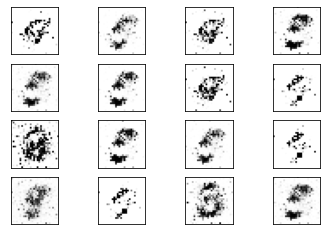

In [15]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])